$$\Large\textbf{SVD: Singilar Value Decomposition for Solar Features}$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy.linalg import inv 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
#Loading table with solar features properties and solar features manually classificated.
table = pd.read_csv('tables/test_classification.csv')

In [3]:
#These steps are necessery if there are regions with no label and there are!
#Manully detected features could be forgotten or hard to recognize, so these aren't labelled.
sunspot_table = table.loc[table['sunspot'] == 1]
filament_table = table.loc[table['filament'] == 1]
plage_table = table.loc[table['plage'] == 1]
flare_table = table.loc[table['flare'] == 1]

#Now we'll have table with all features manually labelled 
#(only one 1 and three 0 in one row for these columns: sunspot, filament, plage, flare)
frames = [sunspot_table, filament_table, plage_table, flare_table]
regions_detected_table = pd.concat(frames, ignore_index=False)

In [4]:
regions_detected_table.head()

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity,min_intensity,max_intensity,...,relative_intensity,relative_min_intensity,relative_max_intensity,complexity,bbox_ratio,elongatedness,sunspot,filament,plage,flare
45,46,815,1129,805,1119,828,1141,7794.225248,4766,9190,...,0.851270,0.520533,1.003713,0.012376,0.956522,0.712871,1,0,0,0
46,47,841,881,830,870,855,895,7178.214000,3936,9138,...,0.783990,0.429882,0.998034,0.018000,1.000000,0.784000,1,0,0,0
51,52,845,1234,838,1225,855,1245,8322.142202,7278,9683,...,0.908928,0.794889,1.057558,0.077982,0.850000,0.449541,1,0,0,0
65,66,965,1215,956,1208,976,1225,7609.211538,4934,9140,...,0.831063,0.538882,0.998253,0.015385,0.850000,0.769231,1,0,0,0
80,81,1192,1208,1180,1195,1206,1222,7119.341463,4161,8929,...,0.777560,0.454456,0.975208,0.015009,0.962963,0.735460,1,0,0,0


In [5]:
#Create table only with properties suitable for classification and manually classificated objects
train_table = regions_detected_table[['centroid-0', 'centroid-1', 'eccentricity', 'circularity', 
                           'elongation', 'bbox_ratio', 'elongatedness', 'solidity', 'complexity', 
                           'relative_intensity', 'relative_min_intensity', 'relative_max_intensity',
                           'sunspot', 'filament', 'plage', 'flare']].copy()

In [6]:
train_table.head()

,centroid-0,centroid-1,eccentricity,circularity,elongation,bbox_ratio,elongatedness,solidity,complexity,relative_intensity,relative_min_intensity,relative_max_intensity,sunspot,filament,plage,flare
45,815,1129,0.367855,0.880313,0.070117,0.956522,0.712871,0.957346,0.012376,0.851270,0.520533,1.003713,1,0,0,0
46,841,881,0.659011,0.922547,0.247867,1.000000,0.784000,0.978474,0.018000,0.783990,0.429882,0.998034,1,0,0,0
51,845,1234,0.827849,0.783980,0.439049,0.850000,0.449541,0.935622,0.077982,0.908928,0.794889,1.057558,1,0,0,0
65,965,1215,0.575060,0.961790,0.181889,0.850000,0.769231,0.977444,0.015385,0.831063,0.538882,0.998253,1,0,0,0
80,1192,1208,0.627887,0.926776,0.221696,0.962963,0.735460,0.977982,0.015009,0.777560,0.454456,0.975208,1,0,0,0


In [7]:
#scale circularity, elongatednes, relative_intensity, relative_min_intensity & relative_max_intensity to range (0,1)
#other properties should be already in this range (0,1)
circ = train_table['circularity']
circ_min_val=circ.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of circilarity: ', circ_min_val)
circ_max_val=circ.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of circularity', circ_max_val)
C = (train_table['circularity']-circ_min_val) / (circ_max_val-circ_min_val)

elon = train_table['elongatedness']
elon_min_val=elon.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of elongatedness: ', elon_min_val)
elon_max_val=elon.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of elongatedness: ', elon_max_val)
E = (train_table['elongatedness']-elon_min_val) / (elon_max_val-elon_min_val)

mean_int = train_table['relative_intensity']
mean_int_min_val=mean_int.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of relative mean intensity: ', mean_int_min_val)
mean_int_max_val=mean_int.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of relative mean intensity: ', mean_int_max_val)
ME = (train_table['relative_intensity']-mean_int_min_val) / (mean_int_max_val-mean_int_min_val)

min_int = train_table['relative_min_intensity']
min_int_min_val=min_int.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of relative min intensity: ', min_int_min_val)
min_int_max_val=min_int.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of relative min intensity: ', min_int_max_val)
MI = (train_table['relative_min_intensity']-min_int_min_val) / (min_int_max_val-min_int_min_val)

max_int = train_table['relative_max_intensity']
max_int_min_val=max_int.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of relative max intensity: ', max_int_min_val)
max_int_max_val=max_int.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of relative max intensity: ', max_int_max_val)
MA = (train_table['relative_max_intensity']-max_int_min_val) / (max_int_max_val-max_int_min_val)

#Checking range of other propeties
sol = train_table['solidity']
sol_min_val=sol.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of solidity: ', sol_min_val)
sol_max_val=sol.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of solidity: ', sol_max_val)

elonion = train_table['elongation']
elonion_min_val=elonion.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of elongation: ',elonion_min_val)
elonion_max_val=elonion.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of elongation: ', elonion_max_val)

comp = train_table['complexity']
comp_min_val=comp.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of complexity: ', comp_min_val)
comp_max_val=comp.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum values of complexity: ', comp_max_val)

ecc = train_table['eccentricity']
ecc_min_val=ecc.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of eccentricity: ', ecc_min_val)
ecc_max_val=ecc.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of eccentricity: ', ecc_max_val)

bb = train_table['bbox_ratio']
bb_min_val=bb.min(axis=0, skipna=None, level=None, numeric_only=None)
print('Minimum value of bounding box ratio: ', bb_min_val)
bb_max_val=bb.max(axis=0, skipna=None, level=None, numeric_only=None)
print('Maximum value of bounding box ratio: ', bb_max_val)

Minimum value of circilarity:  0.094345633685592
Maximum value of circularity 1.21715110294851
Minimum value of elongatedness:  0.056252905625290985
Maximum value of elongatedness:  2.38095238095238
Minimum value of relative mean intensity:  0.5997713920626129
Maximum value of relative mean intensity:  1.6512644390183602
Minimum value of relative min intensity:  0.137043966323667
Maximum value of relative min intensity:  1.30290056726961
Minimum value of relative max intensity:  0.755244755244755
Maximum value of relative max intensity:  2.2854543508509
Minimum value of solidity:  0.235780315388798
Maximum value of solidity:  1.0
Minimum value of elongation:  0.004662357651197001
Maximum value of elongation:  0.931273844546482
Minimum value of complexity:  0.00187969924812
Maximum values of complexity:  0.411214953271028
Minimum value of eccentricity:  0.0964519451516
Maximum value of eccentricity:  0.997635562495934
Minimum value of bounding box ratio:  0.161290322580645
Maximum value

In [8]:
#normalise properties in train table which exceed range <0,1>
train_table['circularity'] = C
train_table['elongatedness'] = E
train_table['relative_intensity'] = ME
train_table['relative_min_intensity'] = MI
train_table['relative_max_intensity'] = MA

In [9]:
train_table.head()

,centroid-0,centroid-1,eccentricity,circularity,elongation,bbox_ratio,elongatedness,solidity,complexity,relative_intensity,relative_min_intensity,relative_max_intensity,sunspot,filament,plage,flare
45,815,1129,0.367855,0.700003,0.070117,0.956522,0.282453,0.957346,0.012376,0.239182,0.328933,0.162376,1,0,0,0
46,841,881,0.659011,0.737618,0.247867,1.000000,0.313050,0.978474,0.018000,0.175197,0.251178,0.158664,1,0,0,0
51,845,1234,0.827849,0.614206,0.439049,0.850000,0.169178,0.935622,0.077982,0.294017,0.564259,0.197563,1,0,0,0
65,965,1215,0.575060,0.772569,0.181889,0.850000,0.306697,0.977444,0.015385,0.219965,0.344672,0.158807,1,0,0,0
80,1192,1208,0.627887,0.741384,0.221696,0.962963,0.292170,0.977982,0.015009,0.169082,0.272257,0.143747,1,0,0,0


In [10]:
#Extracting arrays of properties for classification-> O & array of labels for 4 classes-> V from train_table
data = np.array(train_table)
O = data[:, 2:12].astype(float)
print(O)
V = data[:, 12:16].astype(float)
print(V)

[[0.36785474 0.70000325 0.07011673 ... 0.23918208 0.32893326 0.16237557]
 [0.65901113 0.7376182  0.24786682 ... 0.17519733 0.25117847 0.1586641 ]
 [0.82784932 0.61420614 0.43904946 ... 0.29401652 0.56425862 0.19756322]
 ...
 [0.66820573 0.29178252 0.25602345 ... 0.72047979 0.84956282 0.67825663]
 [0.75291737 0.08686146 0.34188494 ... 0.64195115 0.81788976 0.72328172]
 [0.92731217 0.22013331 0.62571116 ... 0.78921054 0.86648184 0.77087269]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [11]:
#spliting data set into test_data for learning and data for classification
O_train, O_test, V_train, V_test = train_test_split(O, V, random_state=42) 

In [12]:
#print(V_test)
print(O_train, V_train)

[[0.77410354 0.70415803 0.36694099 ... 0.48865073 0.7300398  0.30689084]
 [0.89726326 0.58700668 0.55850408 ... 0.50365819 0.78959923 0.28482066]
 [0.77240244 0.45483062 0.36486658 ... 0.49363463 0.78638293 0.27849596]
 ...
 [0.39161292 0.83913245 0.07986994 ... 0.49625359 0.77282039 0.29583386]
 [0.64254684 0.68584105 0.23375359 ... 0.31221921 0.61475054 0.15813374]
 [0.78471599 0.69080043 0.38014452 ... 0.54150981 0.83514612 0.30798834]] [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [13]:
print(O_train.shape, O_test.shape)

(9353, 10) (3118, 10)


In [14]:
#Estimation of matrix A which should give something like weights for propability classification
#SVD: A = (O^T * O)^(-1) O^T * V
O_train_T = O_train.T
S = inv(np.matmul(O_train_T, O_train))
A = np.matmul(np.matmul(S,O_train_T), V_train)

In [15]:
#Bad... negative values!
print(A)

[[ 2.50108832e-01  6.74336156e-01 -5.25340592e-01  9.96741848e-03]
 [-4.10749985e-01 -1.08814574e+00  1.09149996e+00  1.79286749e-02]
 [-1.57248892e-01 -7.00756558e-01  6.28532844e-01 -1.00916602e-02]
 [ 2.10544287e-01  5.51608864e-02 -9.12061582e-02 -1.43671919e-03]
 [ 3.55799931e-01  1.58573394e-01 -3.31442032e-01  2.07569806e-02]
 [ 1.01902470e+00  8.09933314e-01 -1.03263840e+00 -5.04279394e-02]
 [ 5.33074495e-01 -1.22460056e+00  1.00627390e+00  1.95807317e-02]
 [ 3.26115582e+00 -9.87341891e+00  6.21280878e+00 -5.24950187e-01]
 [-3.10679646e+00  4.70679729e+00 -1.22324395e+00  1.30571854e-01]
 [-1.05536629e+00  3.77352196e+00 -2.63657409e+00  6.24439754e-01]]


In [16]:
#Let's try anyway on out testing data set and get estimation of propabilities, store them in V_svd
V_svd = np.matmul(O_test, A)

In [17]:
#Let's see what was manually detected
V_test

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [18]:
#Let's see what was estimated with SVD
V_svd

array([[ 0.00849747,  0.69073873,  0.31081526, -0.01361419],
       [-0.0449202 ,  0.03564553,  1.03102322, -0.00593771],
       [ 0.06914273, -0.29146353,  1.21240127,  0.01800828],
       ...,
       [ 0.02294793,  0.05321127,  0.96633028,  0.00936885],
       [-0.06226412,  0.20750833,  0.85951368, -0.01252933],
       [ 0.05112571, -0.00671857,  1.02336694, -0.0069032 ]])

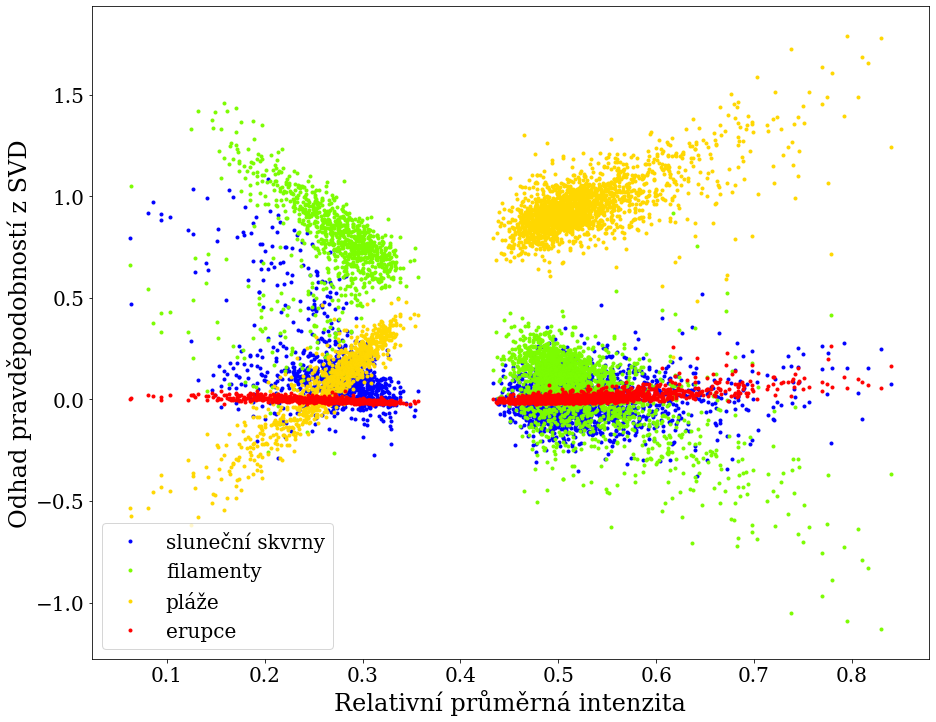

In [19]:
#plot predicted probalities of each class in each row and corresponding intensity (intensity for labelled data
#gave image with 4 classes nicely shown)
#intensity normalised to the range <0,1>
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(O_test[:,7], V_svd[:,0], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(O_test[:,7], V_svd[:,1], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(O_test[:,7], V_svd[:,2], 'o', color='gold', markersize=3, label='pláže')
plt.plot(O_test[:,7], V_svd[:,3], 'ro', markersize=3, label='erupce')
plt.xlabel('Relativní průměrná intenzita', fontsize=24)
plt.ylabel('Odhad pravděpodobností z SVD', fontsize=24)
plt.legend(fontsize=20)

In [20]:
#Let'đ try it for whole array of properties O
V_pred = np.matmul(O, A)

In [21]:
#My predicted values of something close to probabilities (but hey, negative values, values slightly bigger
#than one...)
V_pred

array([[ 0.66421084,  0.09440511,  0.11339104, -0.00925242],
       [ 0.77501927,  0.39449438, -0.20967782,  0.0132662 ],
       [ 0.11717118,  0.81665714,  0.10572595,  0.01416713],
       ...,
       [ 0.02245354, -0.0092977 ,  0.95191721,  0.13098296],
       [-0.3759806 ,  0.7566014 ,  0.48592833,  0.2039622 ],
       [ 0.1005835 , -0.28205238,  1.15890804,  0.15330593]])

In [22]:
#create table from predicted probabilities
predicted = pd.DataFrame(V_pred, columns=['sunspot_pred', 'filament_pred', 'plage_pred', 'flare_pred'])

In [23]:
#reset index of rows, so it can be connected to data
regions_detected_table.reset_index(drop=True, inplace=True)
regions_detected_table.head()

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity,min_intensity,max_intensity,...,relative_intensity,relative_min_intensity,relative_max_intensity,complexity,bbox_ratio,elongatedness,sunspot,filament,plage,flare
0,46,815,1129,805,1119,828,1141,7794.225248,4766,9190,...,0.851270,0.520533,1.003713,0.012376,0.956522,0.712871,1,0,0,0
1,47,841,881,830,870,855,895,7178.214000,3936,9138,...,0.783990,0.429882,0.998034,0.018000,1.000000,0.784000,1,0,0,0
2,52,845,1234,838,1225,855,1245,8322.142202,7278,9683,...,0.908928,0.794889,1.057558,0.077982,0.850000,0.449541,1,0,0,0
3,66,965,1215,956,1208,976,1225,7609.211538,4934,9140,...,0.831063,0.538882,0.998253,0.015385,0.850000,0.769231,1,0,0,0
4,81,1192,1208,1180,1195,1206,1222,7119.341463,4161,8929,...,0.777560,0.454456,0.975208,0.015009,0.962963,0.735460,1,0,0,0


In [24]:
#connect predicted probabilities with table of regions
result = pd.concat([regions_detected_table, predicted], axis=1, ignore_index=False)

In [25]:
#To show table with all objects with their properties, last 8 columns corresponds to manually labelled classes
#and classes predicted by SVD
result.head()

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity,min_intensity,max_intensity,...,bbox_ratio,elongatedness,sunspot,filament,plage,flare,sunspot_pred,filament_pred,plage_pred,flare_pred
0,46,815,1129,805,1119,828,1141,7794.225248,4766,9190,...,0.956522,0.712871,1,0,0,0,0.664211,0.094405,0.113391,-0.009252
1,47,841,881,830,870,855,895,7178.214000,3936,9138,...,1.000000,0.784000,1,0,0,0,0.775019,0.394494,-0.209678,0.013266
2,52,845,1234,838,1225,855,1245,8322.142202,7278,9683,...,0.850000,0.449541,1,0,0,0,0.117171,0.816657,0.105726,0.014167
3,66,965,1215,956,1208,976,1225,7609.211538,4934,9140,...,0.850000,0.769231,1,0,0,0,0.569134,0.337757,0.008714,0.002602
4,81,1192,1208,1180,1195,1206,1222,7119.341463,4161,8929,...,0.962963,0.735460,1,0,0,0,0.682796,0.488954,-0.222314,0.009521


In [26]:
#result.to_csv (r'tables/probability_result.csv', index = False, header=True)

In [27]:
result['sunspot_pred'].index

RangeIndex(start=0, stop=12471, step=1)

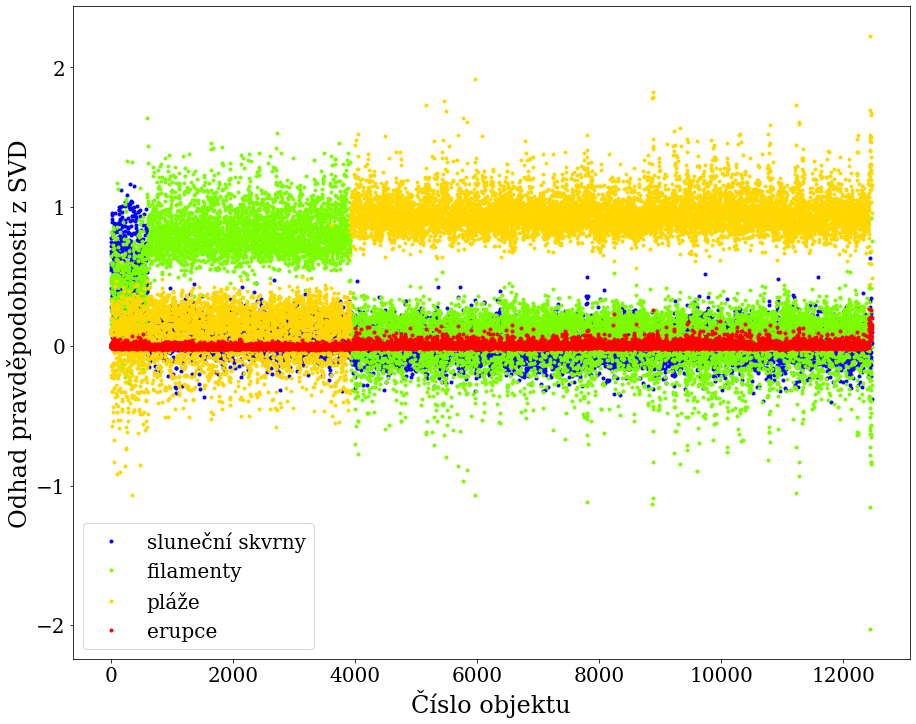

In [28]:
#plot estimated probabilities for each class; classes are sorted in this order: sunspots, filaments,
#plages and flares - thanks sorting we can see how close we are with predicted data to the labelled data
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(result['sunspot_pred'].index, result['sunspot_pred'].values, 'bo', markersize=3, label='sluneční skvrny')
plt.plot(result['filament_pred'].index, result['filament_pred'].values, 'o', color='lawngreen', 
                                          markersize=3, label='filamenty')
plt.plot(result['plage_pred'].index, result['plage_pred'].values, 'o', color='gold', markersize=3, label='pláže')
plt.plot(result['flare_pred'].index, result['flare_pred'].values, 'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24)
plt.ylabel('Odhad pravděpodobností z SVD', fontsize=24)
plt.legend(fontsize=20)

$$\Large\textbf{Graph of features properties with manually labelled data}$$

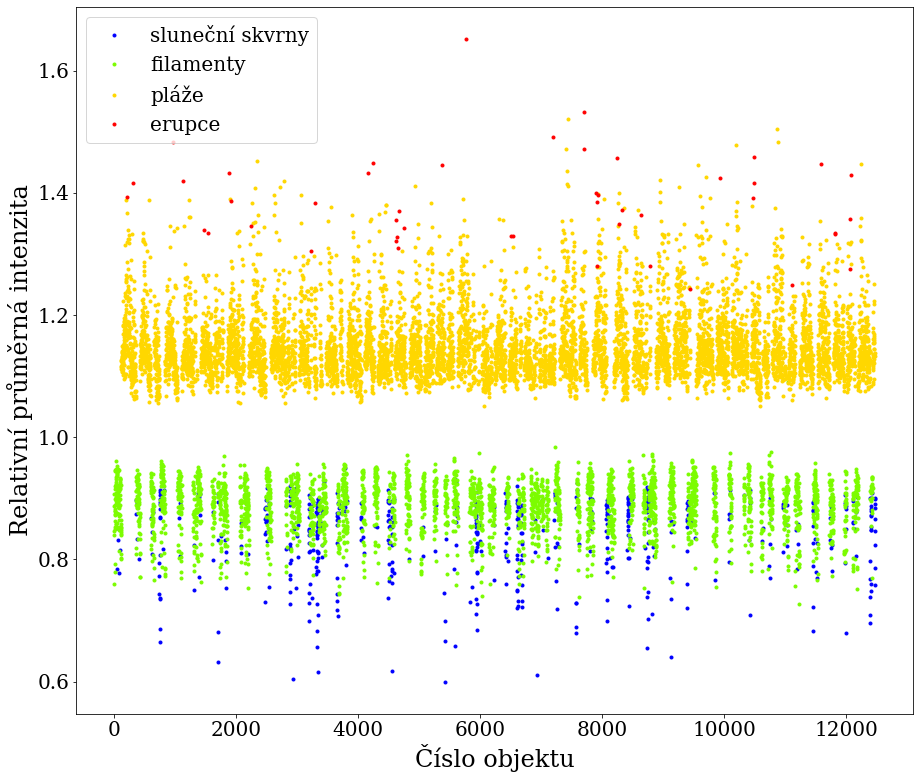

In [29]:
#Plots for intensity of features and their number
#Clearly, it shows that there exist 4 feature classes, doesn't it?
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['relative_intensity'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['relative_intensity'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['relative_intensity'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['relative_intensity'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Relativní průměrná intenzita', fontsize=24, weight='normal')
plt.legend(fontsize=20)

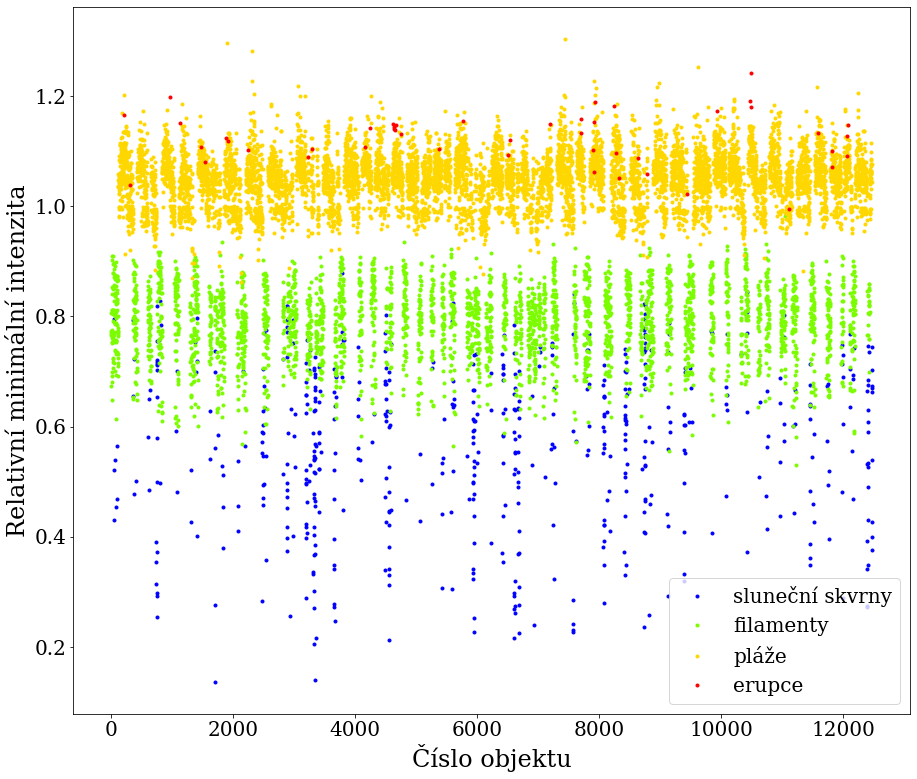

In [30]:
#Plots for min_intensity of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['relative_min_intensity'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['relative_min_intensity'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['relative_min_intensity'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['relative_min_intensity'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Relativní minimální intenzita', fontsize=24, weight='normal')
plt.legend(fontsize=20)

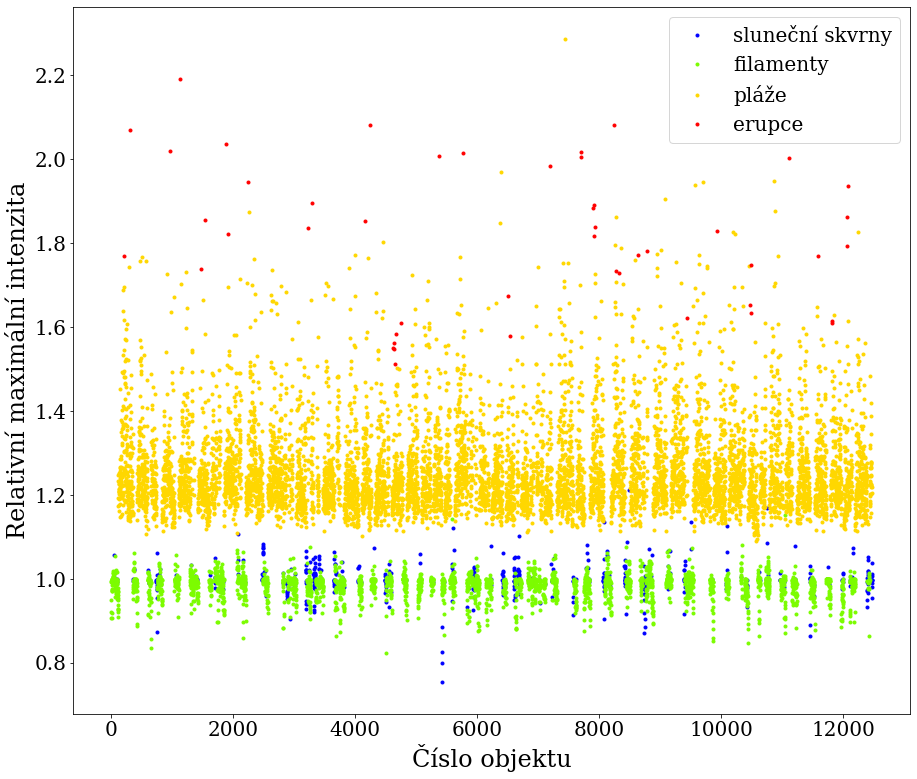

In [31]:
#Plots for max_intensity of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['relative_max_intensity'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['relative_max_intensity'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['relative_max_intensity'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['relative_max_intensity'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Relativní maximální intenzita', fontsize=24, weight='normal')
plt.legend(fontsize=20)

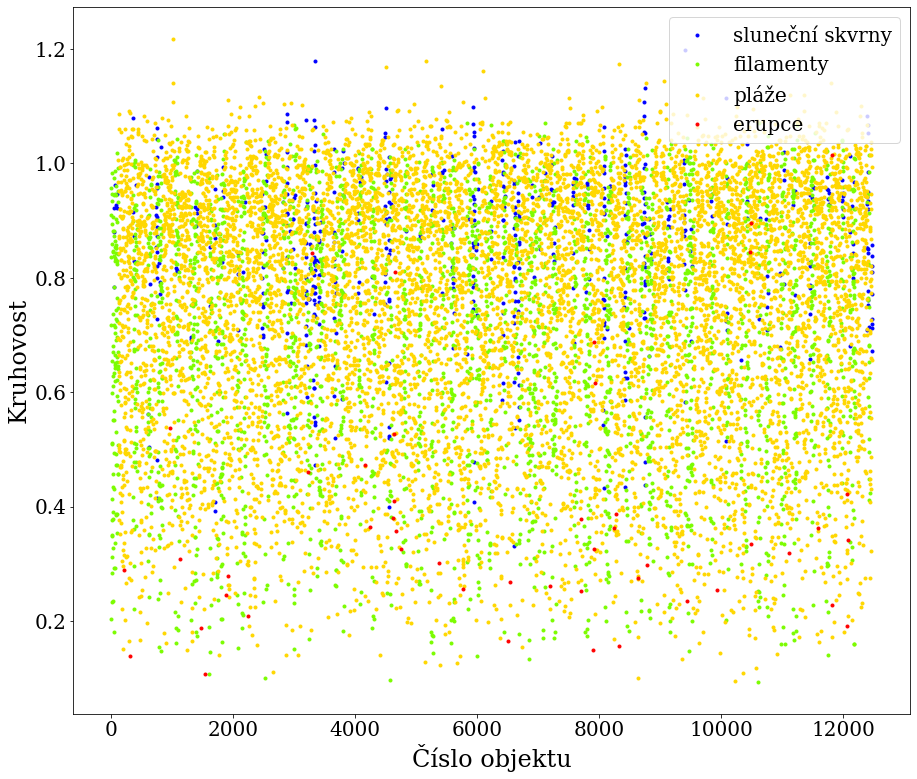

In [32]:
#Plots for circularity of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['circularity'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['circularity'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['circularity'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['circularity'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Kruhovost', fontsize=24, weight='normal')
plt.legend(fontsize=20)

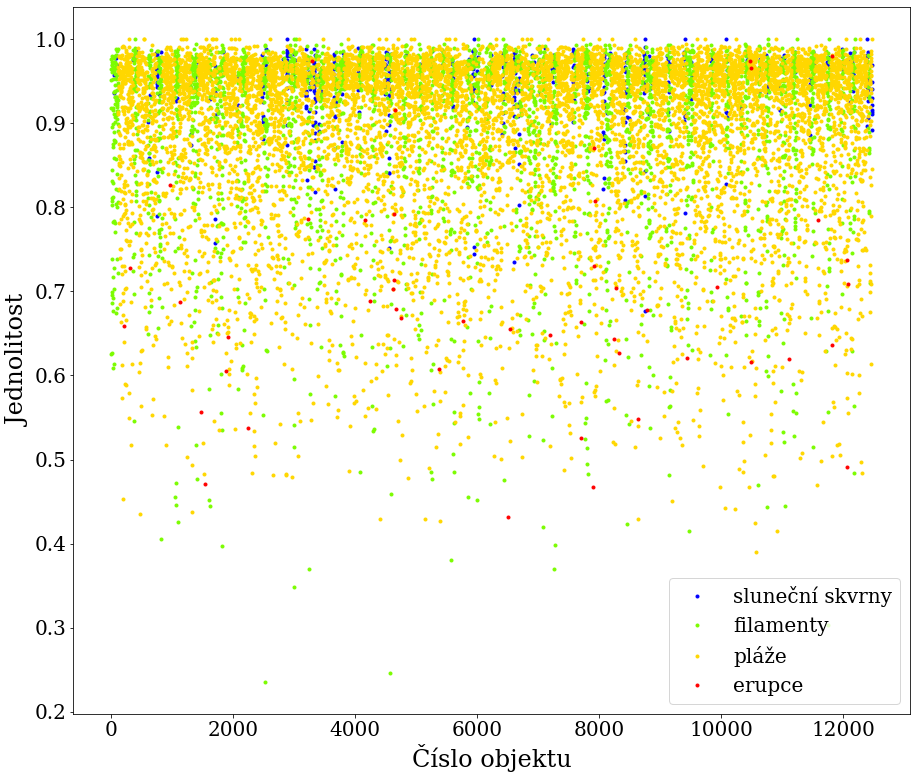

In [33]:
#Plots for solidity of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['solidity'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['solidity'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['solidity'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['solidity'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Jednolitost', fontsize=24, weight='normal')
plt.legend(fontsize=20)

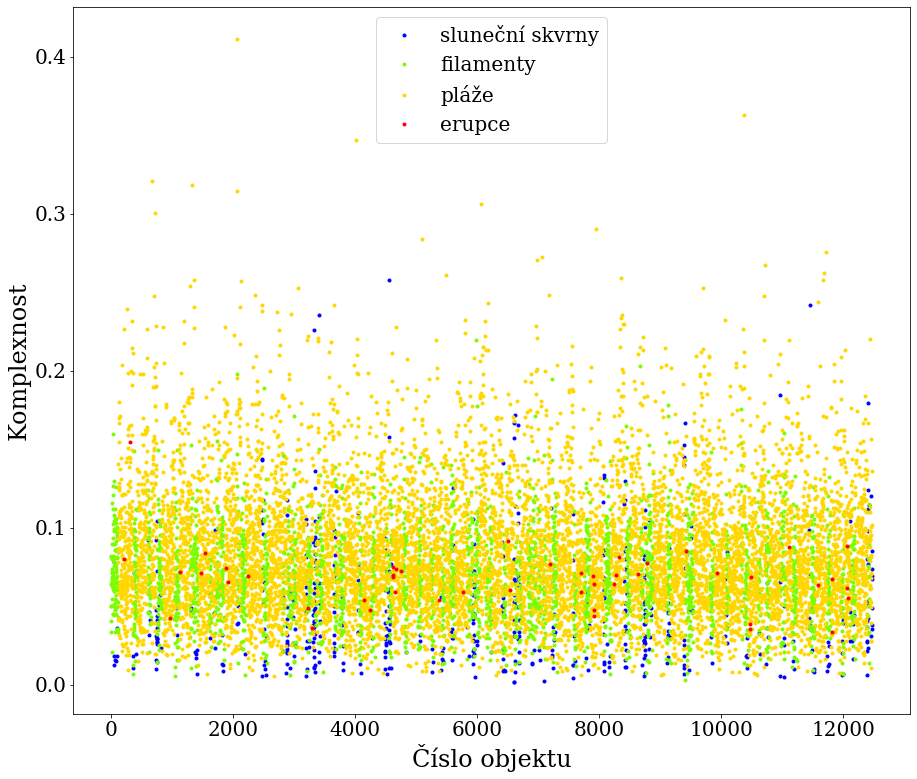

In [34]:
#Plots for complexity of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['complexity'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['complexity'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['complexity'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['complexity'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Komplexnost', fontsize=24, weight='normal')
plt.legend(fontsize=20)

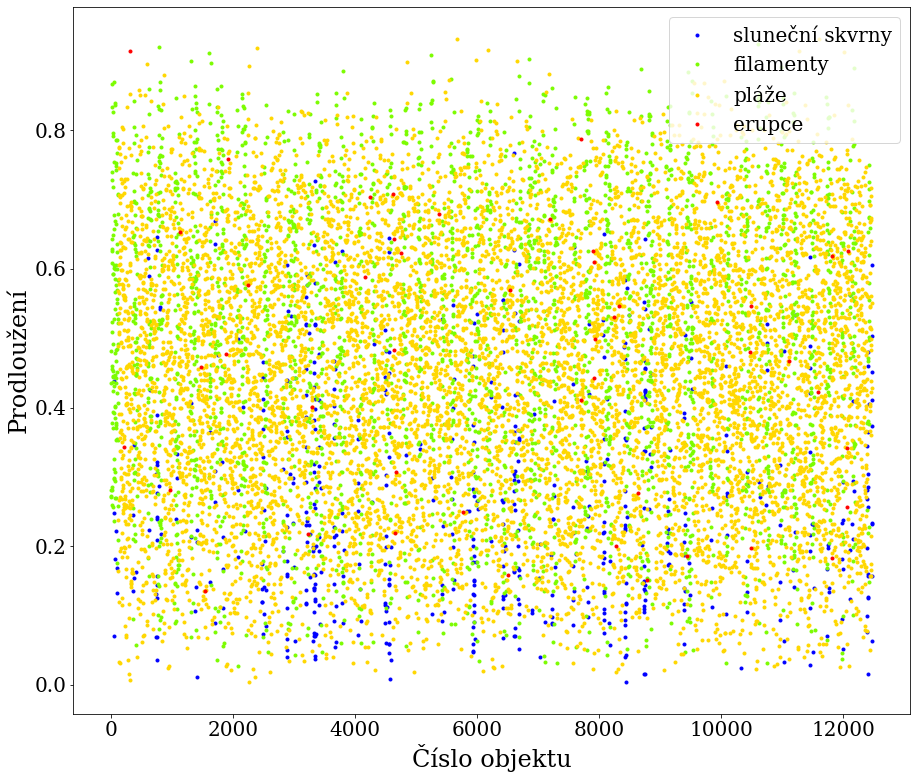

In [35]:
#Plots for elongation of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['elongation'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['elongation'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['elongation'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['elongation'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Prodloužení', fontsize=24, weight='normal')
plt.legend(fontsize=20)

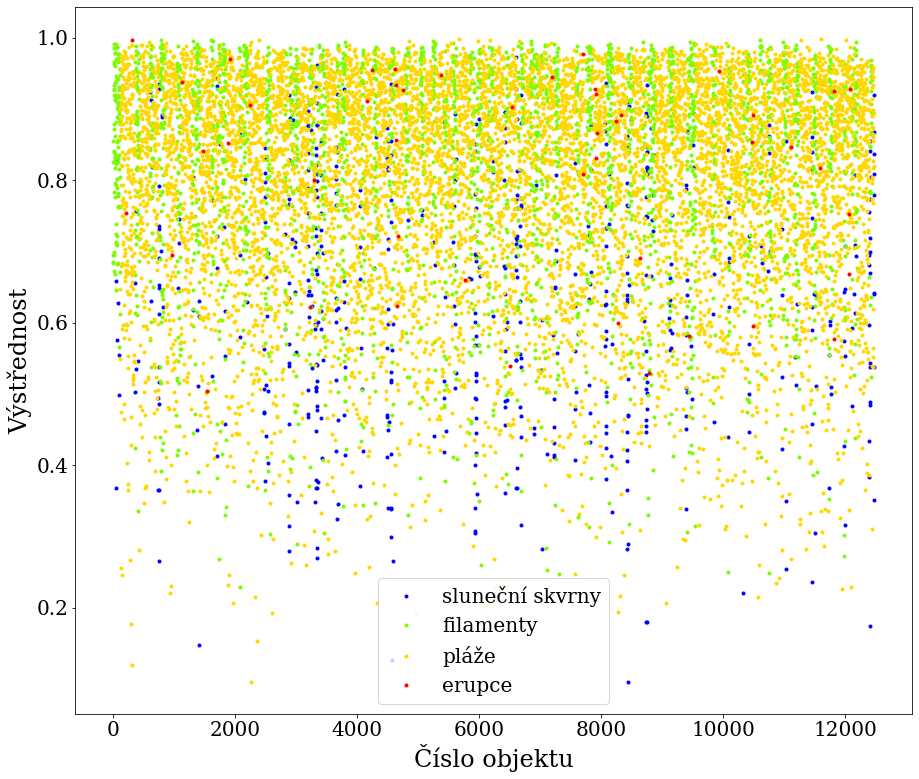

In [36]:
#Plots for eccentricity of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['eccentricity'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['eccentricity'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['eccentricity'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['eccentricity'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Výstřednost', fontsize=24, weight='normal')
plt.legend(fontsize=20)

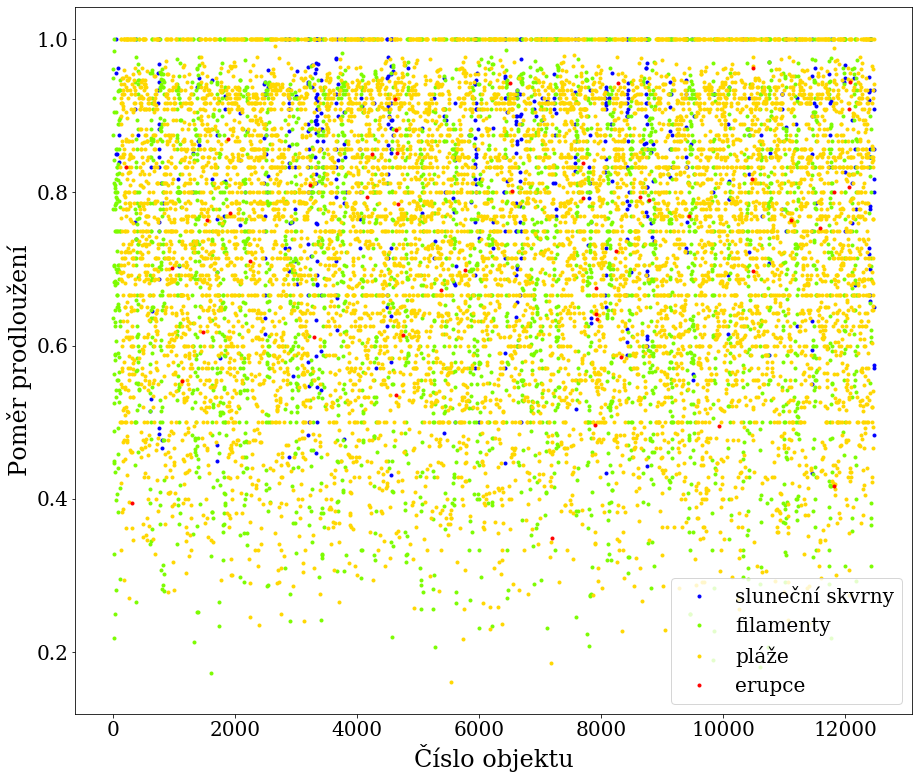

In [37]:
#Plots for bbox_ratio of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['bbox_ratio'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['bbox_ratio'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['bbox_ratio'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['bbox_ratio'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Poměr prodloužení', fontsize=24, weight='normal')
plt.legend(fontsize=20)

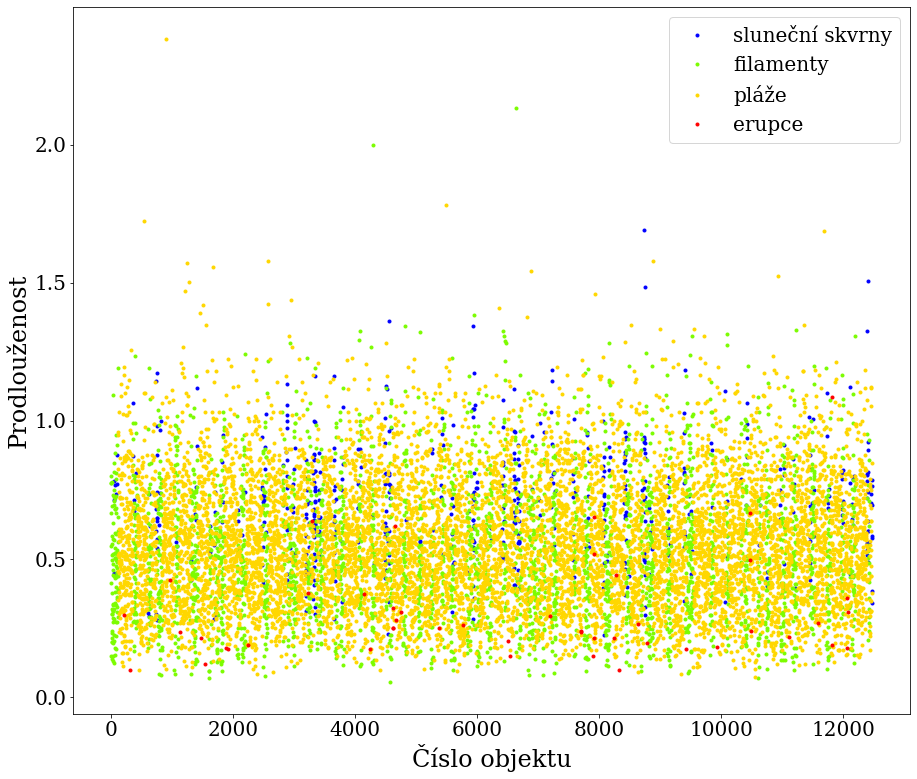

In [38]:
#Plots for elongatedness of features
plt.rcParams['figure.figsize'] = [15, 13]
plt.rcParams['font.size']=20
plt.rcParams["font.weight"] = "normal"
plt.rcParams['font.family'] = ['Serif']

plt.plot(sunspot_table['elongatedness'], 'bo', markersize=3, label='sluneční skvrny')
plt.plot(filament_table['elongatedness'], 'o', color='lawngreen', markersize=3, label='filamenty')
plt.plot(plage_table['elongatedness'], 'o', color='gold', markersize=3, label='pláže')
plt.plot(flare_table['elongatedness'],  'ro', markersize=3, label='erupce')
plt.xlabel('Číslo objektu', fontsize=24, weight='normal')
plt.ylabel('Prodlouženost', fontsize=24, weight='normal')
plt.legend(fontsize=20)